**Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/uber-stock-data/UBER.csv


**Load dataset**

In [2]:
data = pd.read_csv("/kaggle/input/uber-stock-data/UBER.csv")


**Exploratory Data Analysis**

In [3]:
data .head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
1,2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2,2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
3,2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
4,2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,725.000000,725.000000,725.000000,725.000000,725.000000,7.250000e+02
mean,40.166447,40.961435,39.261123,40.107255,40.107255,2.472855e+07
std,9.198940,9.259164,9.075919,9.141862,9.141862,1.691406e+07
min,15.960000,17.799999,13.710000,14.820000,14.820000,3.380000e+06
25%,32.730000,33.419998,31.983000,32.799999,32.799999,1.423060e+07
50%,39.000000,39.959999,38.009998,38.810001,38.810001,2.079540e+07
75%,46.700001,47.520000,45.860001,46.419998,46.419998,3.011960e+07
max,63.250000,64.050003,60.799999,63.180000,63.180000,1.863225e+08


**Preprocessing the Data**

In [5]:
data['Close'] = data['Close'].astype(str)  # Convert the column to string type
data['Close'] = data['Close'].str.replace(',', '', regex=True)  # Remove commas
data['Close'] = data['Close'].astype(float)

In [6]:
print(data['Close'].unique())

[41.57     37.099998 39.959999 41.290001 43.       41.91     41.59
 41.5      41.25     40.470001 41.509998 40.950001 39.939999 39.799999
 40.41     42.75     45.       44.919998 44.16     42.610001 42.450001
 42.169998 44.310001 43.23     43.779999 43.860001 44.860001 44.
 43.09     42.5      45.130001 46.380001 44.27     44.23     43.529999
 42.950001 44.200001 43.700001 43.990002 44.529999 44.130001 43.619999
 43.709999 43.18     43.689999 43.360001 43.759998 43.400002 44.52
 43.880001 42.59     42.139999 41.310001 40.400002 39.049999 39.150002
 39.700001 42.970001 40.049999 37.       36.450001 33.959999 33.220001
 35.23     34.610001 35.290001 34.91     34.       33.43     33.310001
 33.110001 32.59     32.759998 32.57     30.700001 31.99     32.509998
 31.860001 32.240002 33.509998 34.07     33.25     34.43     34.290001
 34.259998 33.82     32.599998 33.       31.299999 31.68     31.57
 30.290001 30.469999 29.15     29.       29.719999 29.67     30.370001
 29.280001 29.07     28.

In [7]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

****Checking Missing Dates in the time series**

In [8]:
from datetime import datetime
a = data['Date'].min()
b = data['Date'].max()

d1 = datetime.strptime(b, "%Y-%m-%d")
d2 = datetime.strptime(a, "%Y-%m-%d")

# difference between dates in timedelta
delta = d2 - d1
print(f'Difference is {delta.days} days')

Difference is -1049 days


In [9]:
data['Date'].nunique()

725

In [10]:
data['Date'] =  pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500


In [11]:
data = data.resample('D').ffill().reset_index()
data['Date'].nunique()

1050

In [12]:
df1 = data[['Close']]
df1

,Close
0,41.570000
1,41.570000
2,41.570000
3,37.099998
4,39.959999
...,...
1045,33.360001
1046,31.980000
1047,33.349998
1048,33.060001


**Plotting time series**

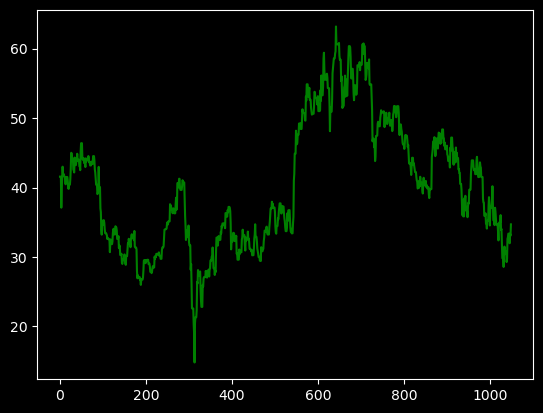

In [13]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.plot(df1, color='green')
plt.show()


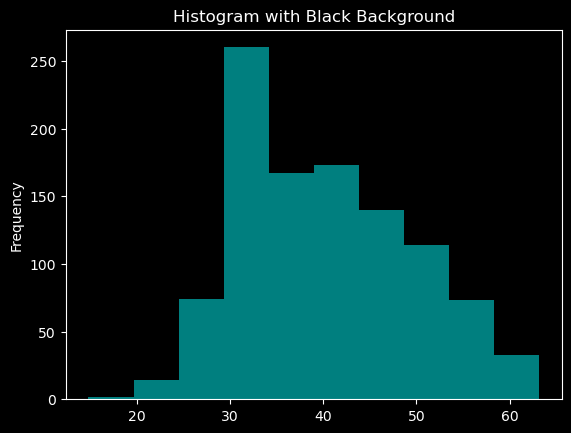

In [14]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
plt.hist(df1, alpha=0.5, color='cyan')
ax.set_ylabel('Frequency')
ax.set_title('Histogram with Black Background')
plt.show()

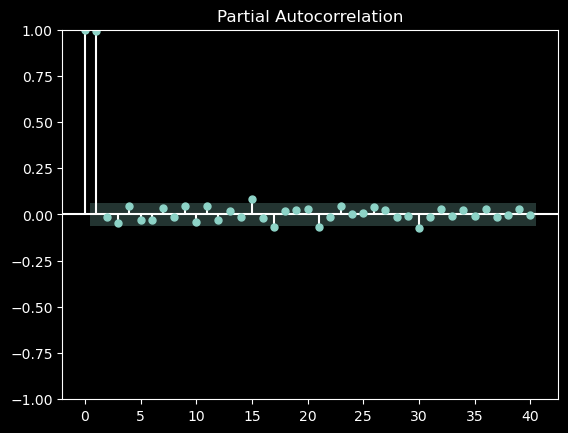

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df1, lags = 40);

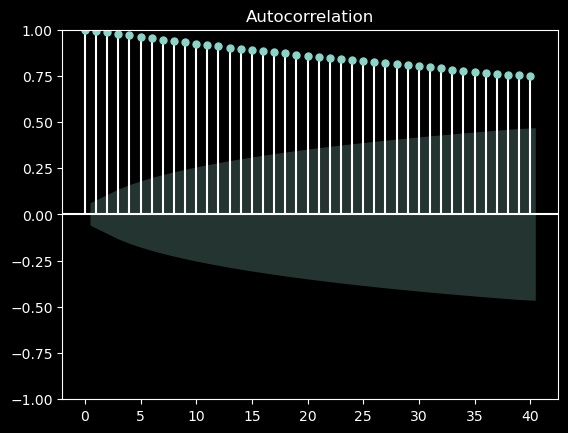

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df1, lags = 40);

****Stationarity Test****

In [17]:
from statsmodels.tsa.stattools import adfuller
a  = adfuller(df1.values, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print('p-value: %f' % a[1])

p-value: 0.336076


**Scaling Data**

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1050, 1)

**Split Data into train and test data**

In [19]:
training_size = int(len(df1)*0.7)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [20]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [22]:
print(X_train.shape), print(y_train.shape)

(634, 100)
(634,)


(None, None)

In [23]:
print(X_test.shape), print(y_test.shape)

(214, 100)
(214,)


(None, None)

In [24]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

**Building Model 1**

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,RNN

In [26]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 10s 371ms/step - loss: 0.0947 - val_loss: 0.0051
Epoch 2/100
10/10 [==============================] - 2s 185ms/step - loss: 0.0210 - val_loss: 0.0047
Epoch 3/100
10/10 [==============================] - 2s 189ms/step - loss: 0.0127 - val_loss: 0.0042
Epoch 4/100
10/10 [==============================] - 2s 184ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 5/100
10/10 [==============================] - 2s 206ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 6/100
10/10 [==============================] - 2s 198ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 7/100
10/10 [==============================] - 2s 192ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 8/100
10/10 [==============================] - 2s 197ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 9/100
10/10 [==============================] - 2s 191ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 10/100
10/10 [==============================] - 2s 192ms/step - loss: 0.0049 - val_l

In [29]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

7/7 [==============================] - 0s 46ms/step


In [30]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

**Evaluating Model**

In [31]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

40.18932238049584

In [32]:
math.sqrt(mean_squared_error(y_test,test_predict))

40.73160803888072

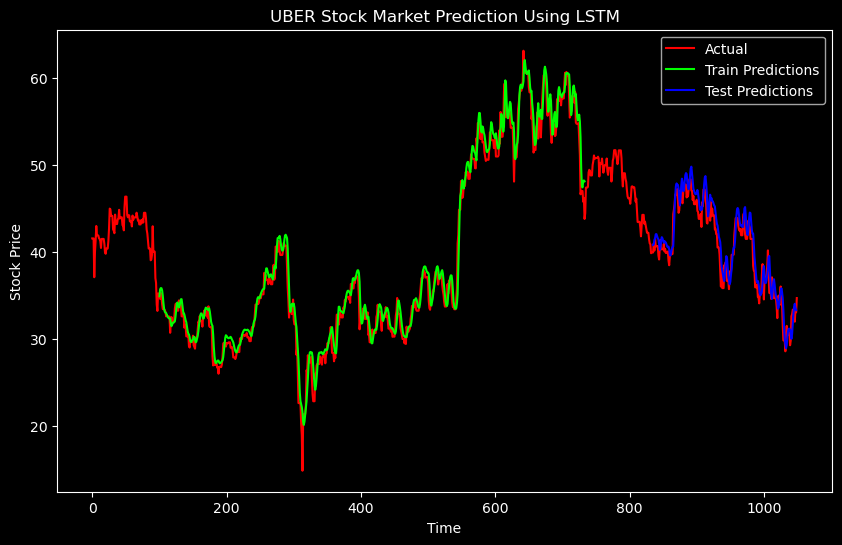

In [33]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.style.use('dark_background')

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

plt.plot(scaler.inverse_transform(df1), color='red', label='Actual')
plt.plot(trainPredictPlot, color='lime', label='Train Predictions')
plt.plot(testPredictPlot, color='blue', label='Test Predictions')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('UBER Stock Market Prediction Using LSTM')
plt.legend()
plt.show()


**Building Model 2**

In [34]:
from tensorflow.keras.layers import LSTM,SimpleRNN
model=Sequential()
model.add(SimpleRNN(50,return_sequences=True,input_shape=(100,1)))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 3s 91ms/step - loss: 0.1006 - val_loss: 0.0305
Epoch 2/100
10/10 [==============================] - 1s 54ms/step - loss: 0.0182 - val_loss: 0.0098
Epoch 3/100
10/10 [==============================] - 1s 53ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 4/100
10/10 [==============================] - 1s 53ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 5/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 6/100
10/10 [==============================] - 1s 56ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/100
10/10 [==============================] - 1s 51ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
10/10 [==============================] - 1s 53ms/step - loss: 0.0013 - val_loss: 9.5507e-04
Epoch 9/100
10/10 [==============================] - 1s 51ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0012 - val_loss: 0.

In [37]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

7/7 [==============================] - 0s 18ms/step


In [38]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

**Evaluating Model**

In [39]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

39.38204137883447

In [40]:
math.sqrt(mean_squared_error(y_test,test_predict))

39.778150367523466

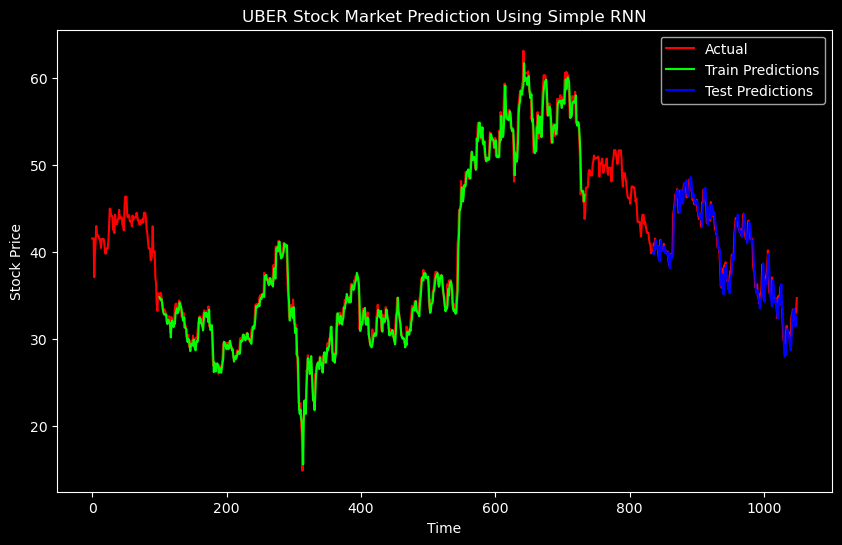

In [41]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(scaler.inverse_transform(df1), color='red', label='Actual')
plt.plot(trainPredictPlot, color='lime', label='Train Predictions')
plt.plot(testPredictPlot, color='blue', label='Test Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('UBER Stock Market Prediction Using Simple RNN')
plt.legend()
plt.show()